# <span style="display: block; text-align: center; color: gold;">Task 2.1 </span>


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [10]:
import pandas as pd

# URL to the TSV file
url = "https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/mcgc.tsv"

# Read the TSV file directly from the URL
data = pd.read_csv(url, sep='\t')

# Display the first few rows to inspect the data
data.head()


,time,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12
0,0,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
1,15,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
2,30,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
3,45,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
4,60,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002


In [11]:
print("Dataset columns:", data.columns.tolist())

Dataset columns: ['time', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']


In [12]:
# Define the replicate labels as given in the note (adjusting last row as needed)
replicate_labels = ["Strain1_Rep1", "Strain1_Rep2", "Strain2_Rep1",
                    "Strain2_Rep2", "Strain3_Rep1", "Strain3_Rep2"]


# We have three experimental groups (A, B, and C). For each group, every two columns are:
# First column: WT, Second column: MUT.
meta = {}
for letter in ['A', 'B', 'C']:
    for i in range(6):  # i=0,...,5 for the six rows
        wt_col = f"{letter}{2*i + 1}"   # e.g., A1, A3, ..., A11
        mut_col = f"{letter}{2*i + 2}"    # e.g., A2, A4, ..., A12
        # Assign metadata for the WT column
        meta[wt_col] = {
            'Experiment': letter,
            'Replicate_Label': replicate_labels[i],
            'Condition': 'WT'
        }
        # Assign metadata for the MUT column
        meta[mut_col] = {
            'Experiment': letter,
            'Replicate_Label': replicate_labels[i],
            'Condition': 'MUT'
        }


In [13]:
# Melt the data so that each row corresponds to a single measurement

df_long = data.melt(id_vars=['time'], var_name='Column', value_name='OD600')

# Map metadata from our dictionary into new columns
df_long['Experiment'] = df_long['Column'].map(lambda x: meta[x]['Experiment'])
df_long['Replicate_Label'] = df_long['Column'].map(lambda x: meta[x]['Replicate_Label'])
df_long['Condition'] = df_long['Column'].map(lambda x: meta[x]['Condition'])

# Extract the strain name from the Replicate_Label (e.g., "Strain1_Rep1" -> "Strain1")
df_long['Strain'] = df_long['Replicate_Label'].apply(lambda x: x.split('_')[0])

print("Long-format data sample:")
print(df_long.head())


Long-format data sample:
   time Column  OD600 Experiment Replicate_Label Condition   Strain
0     0     A1  0.002          A    Strain1_Rep1        WT  Strain1
1    15     A1  0.002          A    Strain1_Rep1        WT  Strain1
2    30     A1  0.002          A    Strain1_Rep1        WT  Strain1
3    45     A1  0.002          A    Strain1_Rep1        WT  Strain1
4    60     A1  0.003          A    Strain1_Rep1        WT  Strain1


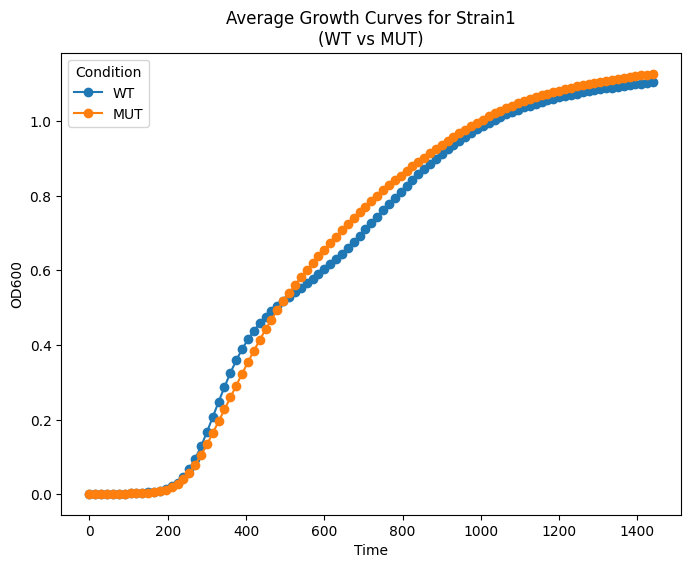

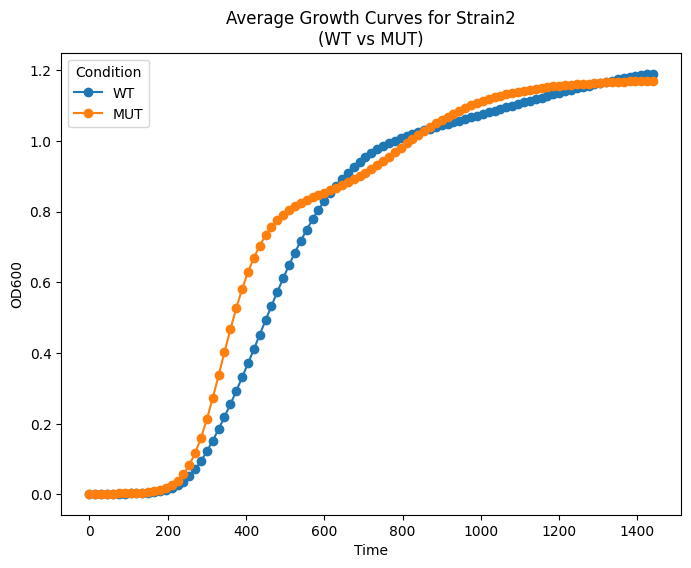

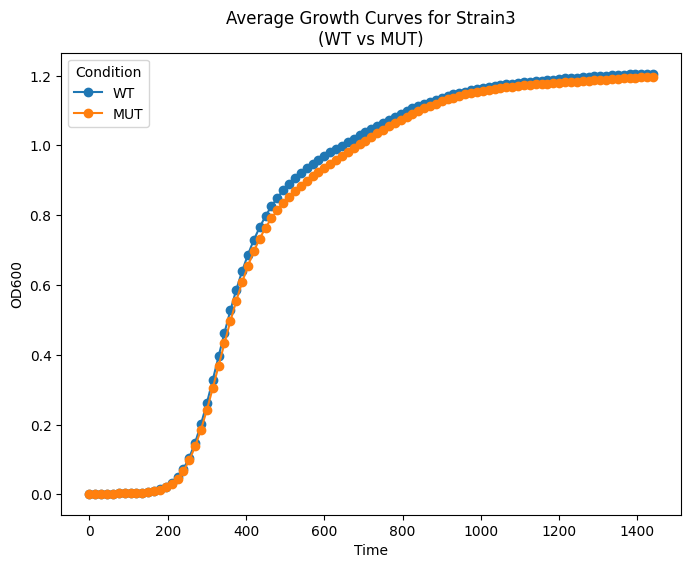

In [14]:
# For each strain (e.g., Strain1, Strain2, Strain3), average the OD600 values over replicates for each condition (WT and MUT) and overlay the curves.
unique_strains = df_long['Strain'].unique()
for strain in unique_strains:
    plt.figure(figsize=(8, 6))
    df_strain = df_long[df_long['Strain'] == strain]

    for condition in ['WT', 'MUT']:
        # Group by time and take the average OD600 for the condition
        avg_curve = df_strain[df_strain['Condition'] == condition].groupby('time')['OD600'].mean().reset_index()
        plt.plot(avg_curve['time'], avg_curve['OD600'], marker='o', label=condition)

    plt.title(f'Average Growth Curves for {strain}\n(WT vs MUT)')
    plt.xlabel('Time')
    plt.ylabel('OD600')
    plt.legend(title='Condition')
    plt.show()


#These overlaid curves allow visual comparison between the WT and MUT growth dynamics.

In [15]:
def time_to_capacity(time, od, threshold=0.95):
    """
    Estimate the time at which the OD600 reaches a specified fraction (default 95%)
    of its maximum value (i.e. the carrying capacity).
    """
    time = np.array(time)
    od = np.array(od)
    max_od = np.max(od)
    capacity_val = threshold * max_od

    # Return the first time point when OD600 is equal or exceeds the threshold.
    for t, od_val in zip(time, od):
        if od_val >= capacity_val:
            return t
    return np.nan

In [16]:
# For each unique combination of Experiment, Replicate_Label, and Condition,
# compute the time to reach 95% of the maximum OD600.
ttc_results = []
grouped = df_long.groupby(['Experiment', 'Replicate_Label', 'Condition'])

for name, group in grouped:
    # Sort by time to ensure proper sequential analysis
    group_sorted = group.sort_values(by='time')
    ttc = time_to_capacity(group_sorted['time'], group_sorted['OD600'])
    exp, rep_label, cond = name
    # Also extract the strain from the replicate label (e.g., "Strain1")
    strain = rep_label.split('_')[0]
    ttc_results.append({
        'Experiment': exp,
        'Replicate_Label': rep_label,
        'Strain': strain,
        'Condition': cond,
        'Time_to_Capacity': ttc
    })

ttc_df = pd.DataFrame(ttc_results)
print("Time-to-capacity results (sample):")
print(ttc_df.head())

Time-to-capacity results (sample):
  Experiment Replicate_Label   Strain Condition  Time_to_Capacity
0          A    Strain1_Rep1  Strain1       MUT              1305
1          A    Strain1_Rep1  Strain1        WT               750
2          A    Strain1_Rep2  Strain1       MUT              1185
3          A    Strain1_Rep2  Strain1        WT               975
4          A    Strain2_Rep1  Strain2       MUT               885


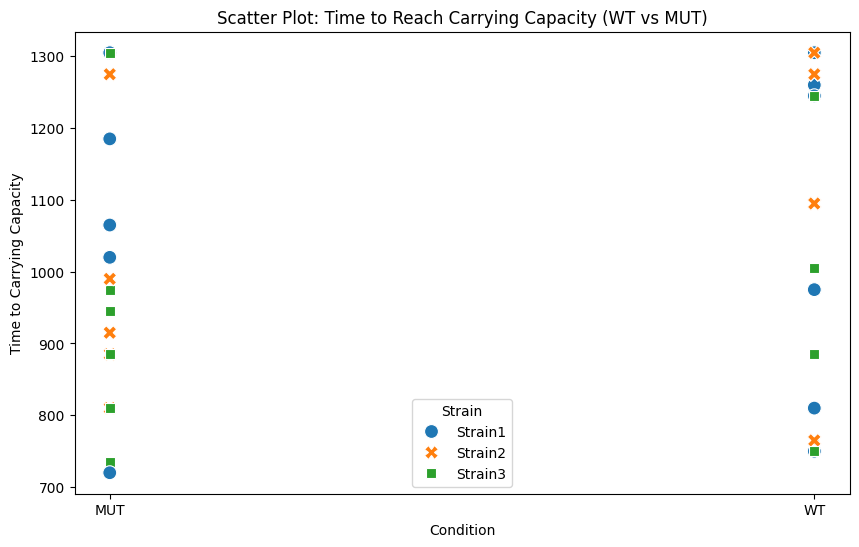

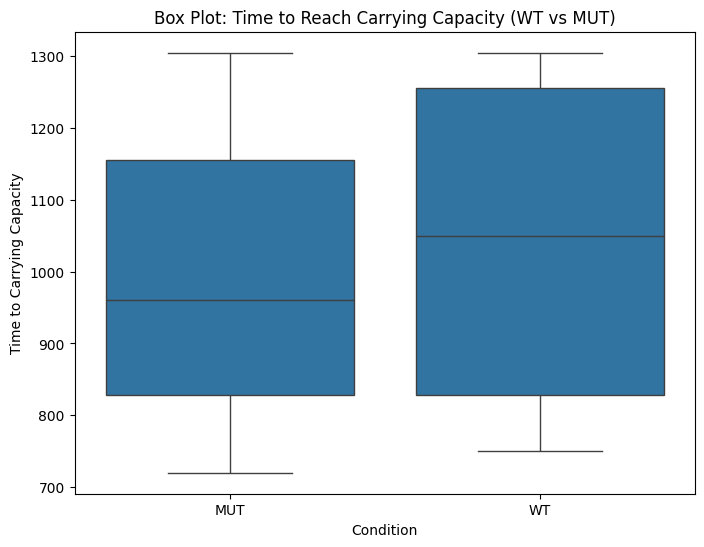

In [17]:
# Scatter plot: each point represents a replicate's time-to-capacity, colored by strain.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ttc_df, x='Condition', y='Time_to_Capacity', hue='Strain', style='Strain', s=100)
plt.title('Scatter Plot: Time to Reach Carrying Capacity (WT vs MUT)')
plt.xlabel('Condition')
plt.ylabel('Time to Carrying Capacity')
plt.show()
# Comment: This scatter plot shows the variability among replicates across conditions and strains.

print("\n")
# Box plot: shows the overall distribution of time-to-capacity for each condition.
plt.figure(figsize=(8, 6))
sns.boxplot(data=ttc_df, x='Condition', y='Time_to_Capacity')
plt.title('Box Plot: Time to Reach Carrying Capacity (WT vs MUT)')
plt.xlabel('Condition')
plt.ylabel('Time to Carrying Capacity')
plt.show()
# Comment: The box plot summarizes the median, quartiles, and potential outliers for each condition.

In [18]:
# Separate the times for WT and MUT (across all strains and replicates)
ttc_wt = ttc_df[ttc_df['Condition'] == 'WT']['Time_to_Capacity'].dropna()
ttc_mut = ttc_df[ttc_df['Condition'] == 'MUT']['Time_to_Capacity'].dropna()

t_stat, p_value = ttest_ind(ttc_wt, ttc_mut, equal_var=False)

print("t-test Results:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("There is a statistically significant difference in the time to reach carrying capacity between WT and MUT conditions.")
else:
    print("There is no statistically significant difference between the conditions.")
# Comment: A significant p-value (< 0.05) would suggest that the mutation (MUT) affects growth dynamics relative to WT.


t-test Results:
t-statistic: 0.595, p-value: 0.556
There is no statistically significant difference between the conditions.


# <span style="display: block; text-align: center; color: gold;">Task 2.2 </span>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/main/Python/Dataset/Pesticide_treatment_data.txt"
df = pd.read_csv(url, sep="\t" , index_col = 0)

# Inspect dataset structure
df


,acetylcarnitine,aconitic_acid,adenine,adenosine_cyclic_monophosphate,adenosine_monophosphate,adenosine_triphosphate,adipic_acid,allantoin,alpha_ketoglutaric_acid,aminoadipic_acid,...,uric_acid,uridine,uridine_diphosphohexose,uridine_monophosphate,uridine_triphosphate,valine,xanthine,xanthosine,xylitol,xylulose_5_phosphate
WT_DMSO_1,7.000000,-19.447639,-0.066413,-1.917890,2.967939,12.728842,1.165878,7.151822,3.897284,6.566451,...,2.575356,3.013875,9.541007,4.607716,9.069961,12.140469,3.880476,-0.917890,5.148667,7.900345
WT_pesticide_0_1,7.035531,-19.445951,-0.363286,-1.700000,5.340498,12.718995,1.136285,6.941596,4.398953,6.442069,...,2.563368,2.825857,9.418045,6.860882,9.001867,11.849802,3.716842,-0.761835,5.937027,8.535654
WT_pesticide_8h_1,6.773425,-19.443194,0.048875,-1.632303,3.705703,12.705989,0.689625,6.647828,4.152670,6.396937,...,2.153572,1.956799,9.459292,5.339439,9.083393,11.580424,3.790487,-0.875574,6.490034,7.902034
WT_pesticide_24h_1,7.900711,-19.442015,0.195580,-2.173653,3.278473,12.796767,0.575285,7.125809,4.161241,6.336561,...,1.923208,1.300278,9.340211,4.781189,8.996237,11.546205,3.424606,-1.058176,5.526786,7.836253
mutant_DMSO_1,6.498987,-19.442820,0.761424,-3.291687,5.197760,12.563605,0.219275,6.917888,4.353611,6.238329,...,1.997410,2.141272,9.261630,6.447419,8.854404,11.775306,3.461864,-1.121762,5.464536,7.695151
mutant_pesticide_0_1,6.920949,-19.442771,-1.394874,-3.434402,6.130594,12.286961,0.524956,7.393205,4.179489,6.180103,...,2.735523,2.832384,9.258552,7.399630,8.520844,11.641244,3.689144,-1.356400,5.302187,7.703158
mutant_pesticide_8h_1,6.000000,-19.447581,1.046610,-1.417671,5.265194,12.920728,1.236833,7.288153,4.442151,6.507581,...,1.245294,3.029565,9.850806,6.823915,9.272101,11.817850,3.699347,-0.815006,6.075369,8.198878
mutant_pesticide_24h_1,5.935605,-19.443570,0.227218,-1.683515,4.834391,12.832976,0.479984,6.608347,4.170481,6.404160,...,1.505519,1.352109,9.543812,6.172724,9.170855,11.500276,2.978691,-1.005443,5.963512,7.932446


In [ ]:
df.to_csv('pesticide_treatment_data.csv', index=False)

In [ ]:
df.shape

(8, 109)

In [ ]:
df.index.tolist()

['WT_DMSO_1',
 'WT_pesticide_0_1',
 'WT_pesticide_8h_1',
 'WT_pesticide_24h_1',
 'mutant_DMSO_1',
 'mutant_pesticide_0_1',
 'mutant_pesticide_8h_1',
 'mutant_pesticide_24h_1']

In [ ]:
df.columns.tolist()

['acetylcarnitine',
 'aconitic_acid',
 'adenine',
 'adenosine_cyclic_monophosphate',
 'adenosine_monophosphate',
 'adenosine_triphosphate',
 'adipic_acid',
 'allantoin',
 'alpha_ketoglutaric_acid',
 'aminoadipic_acid',
 'arabitol',
 'arginine',
 'argininosuccinic_acid',
 'asparagine',
 'aspartic_acid',
 'butyrylcarnitine',
 'carnitine',
 'citramalic_acid',
 'citric_acid_isocitric_acid',
 'citrulline',
 'creatine',
 'creatine_phosphate',
 'creatinine',
 'cystathionine',
 'cystine',
 'cytidine_triphosphate',
 'deoxy_methylthio_adenosine',
 'deoxyadenosine_triphosphate',
 'deoxycytidine_monophosphate',
 'deoxythymidine_triphosphate',
 'deoxyuridine',
 'dihydroxyacetone_phosphate',
 'dihydroxyisovalerate',
 'flavin_adenine_dinucleotide',
 'folic_acid',
 'fructose_1_6_biphosphate',
 'gamma_glu_cys',
 'glutamic_acid',
 'glutamine',
 'gluthathione_oxidized',
 'glyceric_acid',
 'glycine',
 'guanosine',
 'guanosine_triphosphate',
 'hexose',
 'hexose_1_phosphate',
 'hexose_6_phosphate',
 'histid

In [ ]:
# 2. Calculate ΔM for Wild Type and Mutant.
# =============================================================================
# ΔM is defined as: ΔM = (24h_pesticide – DMSO)
wt_deltaM = df.loc['WT_pesticide_24h_1'] - df.loc['WT_DMSO_1']
mutant_deltaM = df.loc['mutant_pesticide_24h_1'] - df.loc['mutant_DMSO_1']

# Create a summary DataFrame with one row per metabolite.
deltaM_df = pd.DataFrame({
    'Metabolite': wt_deltaM.index,
    'WT_deltaM': wt_deltaM.values,
    'Mutant_deltaM': mutant_deltaM.values
})


In [ ]:
deltaM_df.head()

,Metabolite,WT_deltaM,Mutant_deltaM
0,acetylcarnitine,0.900711,-0.563382
1,aconitic_acid,0.005624,-0.000749
2,adenine,0.261993,-0.534206
3,adenosine_cyclic_monophosphate,-0.255763,1.608172
4,adenosine_monophosphate,0.310535,-0.363369


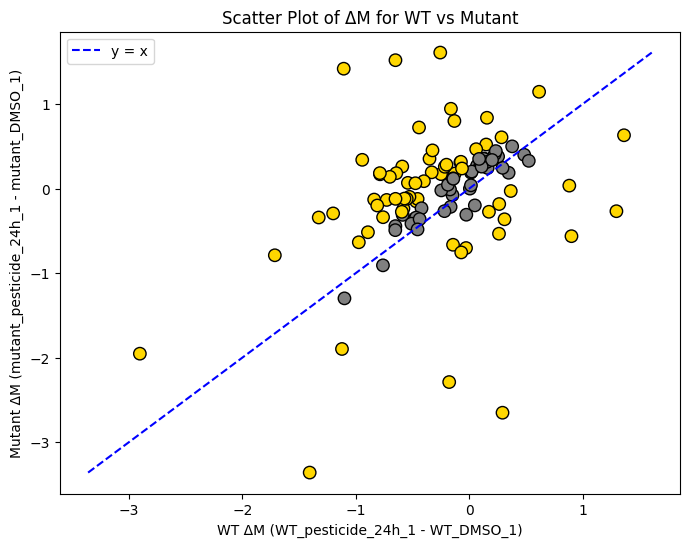

In [ ]:
# 3. Compute residuals and generate the scatter plot.
# =============================================================================
# The reference line is y = x; therefore, the residual for each metabolite is:
# residual = (Mutant_deltaM - WT_deltaM)
deltaM_df['residual'] = deltaM_df['Mutant_deltaM'] - deltaM_df['WT_deltaM']

# Set a residual cutoff (adjustable, here chosen as 0.3).
residual_cutoff = 0.3
deltaM_df['color'] = np.where(deltaM_df['residual'].abs() <= residual_cutoff, 'grey', 'gold')

# Create the scatter plot.
plt.figure(figsize=(8, 6))
plt.scatter(deltaM_df['WT_deltaM'], deltaM_df['Mutant_deltaM'],
            c=deltaM_df['color'], s=80, edgecolor='k')
plt.xlabel('WT ΔM (WT_pesticide_24h_1 - WT_DMSO_1)')
plt.ylabel('Mutant ΔM (mutant_pesticide_24h_1 - mutant_DMSO_1)')
plt.title('Scatter Plot of ΔM for WT vs Mutant')

# Plot the reference line y = x.
min_val = min(deltaM_df['WT_deltaM'].min(), deltaM_df['Mutant_deltaM'].min())
max_val = max(deltaM_df['WT_deltaM'].max(), deltaM_df['Mutant_deltaM'].max())
x_vals = np.linspace(min_val, max_val, 100)
plt.plot(x_vals, x_vals, color='blue', linestyle='--', label='y = x')
plt.legend()
plt.show()

In [ ]:
# This scatter plot shows how each metabolite’s change (ΔM) in the mutant compares
# to the wild type. Points near the diagonal (y=x) suggest metabolites with
# similar responses in both genotypes, while those farther from the line indicate
# metabolites for which the mutant’s response diverges substantially from
# the wild type. The color coding (grey vs. gold) highlights which metabolites
# fall within a chosen residual cutoff, revealing a cluster of metabolites
# that behave similarly (grey) and a set of outliers (gold) with
# notably different responses

In [ ]:
# 4. Identify metabolites outside the residual cutoff.
# =============================================================================
outlier_metabolites = deltaM_df.loc[deltaM_df['residual'].abs() > residual_cutoff, 'Metabolite']
print(f"Metabolites with |residual| > {residual_cutoff}:")
print(outlier_metabolites.tolist())

Metabolites with |residual| > 0.3:
['acetylcarnitine', 'adenine', 'adenosine_cyclic_monophosphate', 'adenosine_monophosphate', 'adipic_acid', 'alpha_ketoglutaric_acid', 'aminoadipic_acid', 'arabitol', 'arginine', 'argininosuccinic_acid', 'asparagine', 'aspartic_acid', 'butyrylcarnitine', 'carnitine', 'citramalic_acid', 'citrulline', 'creatine', 'creatine_phosphate', 'creatinine', 'cystathionine', 'cystine', 'deoxyadenosine_triphosphate', 'deoxythymidine_triphosphate', 'deoxyuridine', 'dihydroxyisovalerate', 'gamma_glu_cys', 'glutamine', 'glycine', 'guanosine', 'hexose', 'hexose_6_phosphate', 'histidine', 'hydroxy_glutamic_acid', 'hydroxyglutaric_acid', 'hypoxanthine', 'isoleucine', 'itaconic_acid', 'lactic_acid', 'leucine', 'maleic_acid', 'methionine', 'myristoylcarnitine', 'n_acetylglutamic_acid', 'n_carbamyl_glutamic_acid', 'o_phosphorylethanolamine', 'orotic_acid', 'oxamic_acid', 'phenylalanine', 'phospho_serine', 'pyridoxal_hydrochloride', 'pyruvic_acid', 'riboflavin', 'ribose_5_ph

Selected metabolites for time-course plots: ['acetylcarnitine', 'adenine', 'adenosine_cyclic_monophosphate', 'adenosine_monophosphate', 'adipic_acid', 'alpha_ketoglutaric_acid']


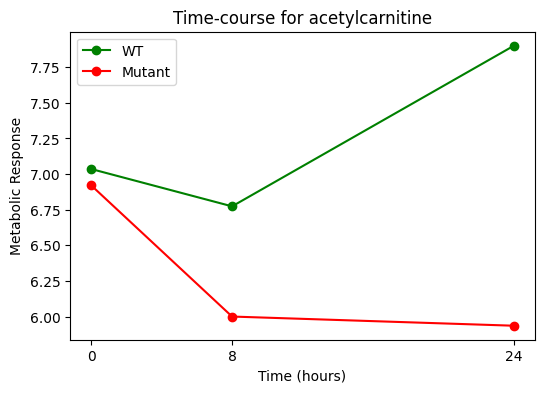

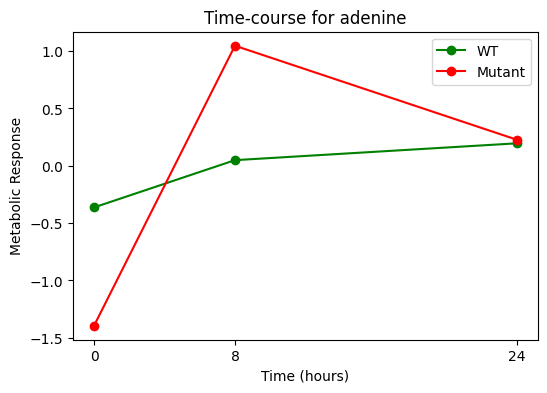

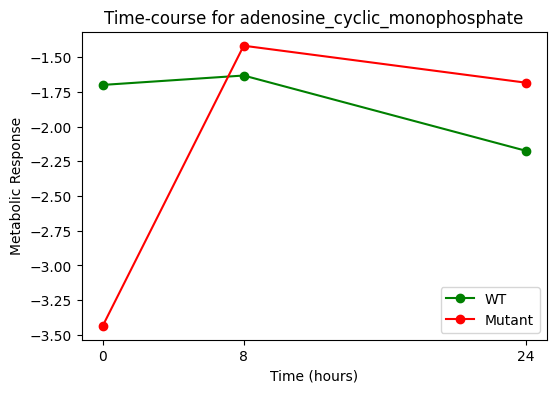

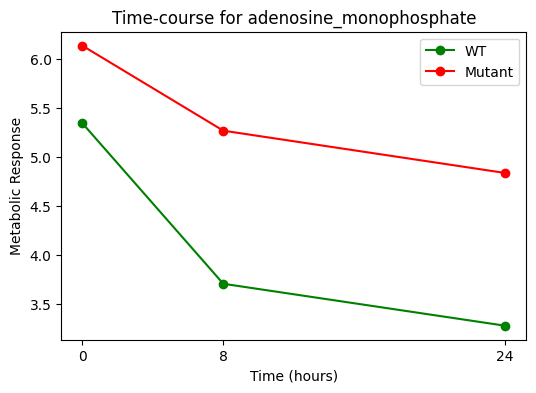

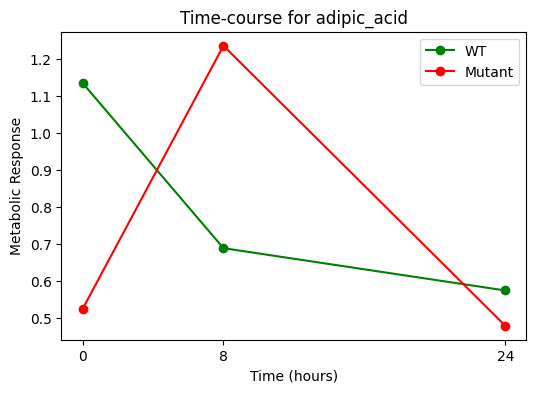

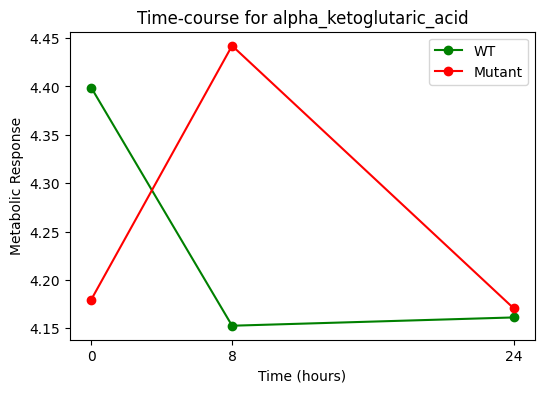

In [ ]:
# 5. Generate time-course plots for 6 selected outlier metabolites.
# =============================================================================
# For the time course, we use the pesticide treatment time points:
# 0h, 8h, and 24h.
time_points = [0, 8, 24]
wt_time_indices = ['WT_pesticide_0_1', 'WT_pesticide_8h_1', 'WT_pesticide_24h_1']
mutant_time_indices = ['mutant_pesticide_0_1', 'mutant_pesticide_8h_1', 'mutant_pesticide_24h_1']

# Select the first 6 outlier metabolites (if at least 6 exist).
selected_metabolites = outlier_metabolites.tolist()[:6]
print("Selected metabolites for time-course plots:", selected_metabolites)

# Plot the time-course for each selected metabolite.
for met in selected_metabolites:
    wt_values = df.loc[wt_time_indices, met].values
    mutant_values = df.loc[mutant_time_indices, met].values

    plt.figure(figsize=(6, 4))
    plt.plot(time_points, wt_values, marker='o', label='WT', color='green')
    plt.plot(time_points, mutant_values, marker='o', label='Mutant', color='red')
    plt.title(f"Time-course for {met}")
    plt.xlabel('Time (hours)')
    plt.ylabel('Metabolic Response')
    plt.xticks(time_points)
    plt.legend()
    plt.show()

    print("\n")

    # Comments (to be refined after inspecting the plots):
    # - Compare the trajectories between WT and Mutant over time.
    # - Note any divergence or convergence in the metabolic responses.
    # - These trends might indicate how the engineered mutation alters the response to the pesticide.

In [ ]:
# Acetylcarnitine

# Observation: The wild type (WT) level dips slightly at 8 h but then rises at 24 h,
#  while the mutant level consistently declines over time.
# Interpretation: WT may recover or increase production of this metabolite by 24 h,
#  whereas the mutant shows a progressive decrease.


# Adenine

# Observation: WT gradually increases from 0 h to 24 h. The mutant jumps sharply
# from a negative value at 0 h to a peak at 8 h, then drops at 24 h.
# Interpretation: The mutant’s early surge could indicate a transient overproduction,
# stabilizing closer to the WT level by 24 h.


# Adenosine_cyclic_monophosphate

# Observation: Both WT and mutant begin with negative values, but the mutant starts
#  lower. By 8 h, the mutant rises near the WT, and both slightly decrease again at 24 h.
# Interpretation: Despite initial differences, both genotypes converge to similarly
#  low levels at 24 h, suggesting a comparable downregulation of this metabolite over time.


# Adenosine_monophosphate

# Observation: Both WT and mutant decrease from 0 h to 24 h, but the mutant is
#  consistently higher until the final time point, where it still remains above the WT.
# Interpretation: The downward trend in both genotypes suggests a similar response,
#  but the mutant’s higher overall levels might reflect a sustained upregulation of AMP.


# Adipic_acid

# Observation: WT starts high at 0 h and steadily declines through 24 h.
# The mutant begins lower, peaks at 8 h, and then drops below the WT by 24 h.
# Interpretation: The mutant’s mid‐time spike could indicate a transient metabolic
#  shift, whereas WT shows a more gradual, continuous decrease.


# Alpha_ketoglutaric_acid

# Observation: WT begins slightly higher, dips at 8 h, and recovers partially
#  by 24 h. The mutant takes an opposite path, rising at 8 h before falling again at 24 h.
# Interpretation: The “mirror” trends suggest each genotype adjusts this metabolite
#  differently over time, potentially reflecting distinct metabolic strategies to cope with the pesticide.

# <span style="display: block; text-align: center; color: gold;">Task 2.3 </span>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sift_url = "https://raw.githubusercontent.com/HackBio-Internship/public_datasets/main/R/datasets/sift.tsv"
foldx_url = "https://raw.githubusercontent.com/HackBio-Internship/public_datasets/main/R/datasets/foldX.tsv"

# Use sep='\s+' to split on one or more whitespace characters.
sift_df = pd.read_csv(sift_url, sep='\s+')
foldx_df = pd.read_csv(foldx_url, sep='\s+')

In [ ]:

print("SIFT columns:", sift_df.columns.tolist())
print("FoldX columns:", foldx_df.columns.tolist())

SIFT columns: ['Protein', 'Amino_Acid', 'sift_Score']
FoldX columns: ['Protein', 'Amino_Acid', 'foldX_Score']


In [ ]:
# ----- 2. Create the specific_Protein_aa column in both datasets -----
sift_df['specific_Protein_aa'] = sift_df['Protein'].astype(str) + "_" + sift_df['Amino_Acid'].astype(str)
foldx_df['specific_Protein_aa'] = foldx_df['Protein'].astype(str) + "_" + foldx_df['Amino_Acid'].astype(str)

# ----- 3. Merge the two datasets on the specific_Protein_aa column -----
merged_df = pd.merge(sift_df, foldx_df, on='specific_Protein_aa', suffixes=('_sift', '_foldx'))
print("Merged dataframe shape:", merged_df.shape)



Merged dataframe shape: (75337, 7)


Number of mutations deleterious in both SIFT and FoldX: 5261
Frequency table for original amino acids in deleterious mutations:
 original_aa
G    1307
L     739
A     640
P     470
V     380
R     227
I     212
Y     172
D     171
F     169
S     158
T     126
W     108
M      87
C      74
N      60
E      50
H      47
Q      40
K      24
Name: count, dtype: int64


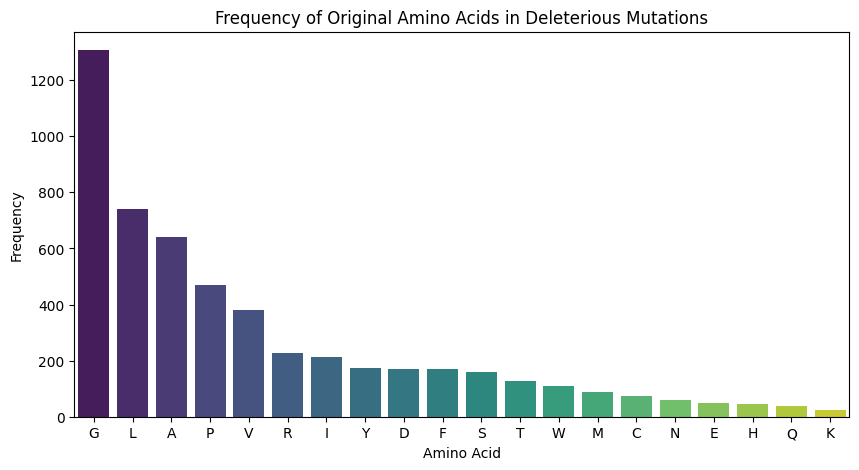


Amino acid with the highest frequency (most impact): G


In [ ]:
# ----- 4. Filter for mutations that affect both structure and function -----
# Criteria:
# - SIFT score < 0.05 is considered deleterious (functional impact).
# - FoldX score > 2 (kCal/mol) is considered deleterious (structural impact).
filtered_df = merged_df[(merged_df['sift_Score'] < 0.05) & (merged_df['foldX_Score'] > 2)].copy()

# ----- 5. Study the amino acid substitution nomenclature -----
# For an amino acid substitution like "E63D", the first letter ("E") is the original (wild-type) amino acid.
# We extract it from the 'Amino_Acid_sift' column (you could also use the one from FoldX, as they should match).
# Use .loc to add the 'original_aa' column to avoid SettingWithCopyWarning.
filtered_df.loc[:, 'original_aa'] = filtered_df['Amino_Acid_sift'].str[0]

print("Number of mutations deleterious in both SIFT and FoldX:", filtered_df.shape[0])



# ----- 6. Generate a frequency table for the original amino acids -----
aa_freq = filtered_df['original_aa'].value_counts()
print("Frequency table for original amino acids in deleterious mutations:\n", aa_freq)

# ----- Plotting the frequency with a bar plot -----
# Convert the frequency Series to a DataFrame for easier plotting.
aa_freq_df = aa_freq.reset_index()
aa_freq_df.columns = ['Amino_Acid', 'Frequency']

plt.figure(figsize=(10, 5))
# To fix the FutureWarning, we assign hue using the same variable as x and then remove the legend.
ax = sns.barplot(x='Amino_Acid', y='Frequency', data=aa_freq_df, palette="viridis", hue='Amino_Acid', dodge=False)
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.title('Frequency of Original Amino Acids in Deleterious Mutations')
plt.show()

# ----- 8. Identify the amino acid with the most impact -----
most_impacted_aa = aa_freq.idxmax()
print("\nAmino acid with the highest frequency (most impact):", most_impacted_aa)

# ----- 9. Brief description based on frequency -----
# For instance:
# "Amino acids with more than 100 occurrences in deleterious mutations are likely to be critical for protein stability
#  and function. Their structural properties—such as size, charge, and hydrophobicity—make them sensitive to substitutions.
#  This high frequency suggests that mutations at these positions disrupt both the structure and function of the protein."

In [ ]:
  # These results show that 5261 mutations are classified as deleterious by both
  # SIFT (< 0.05) and FoldX (> 2 kCal/mol). Among these, glycine (G) stands out
  # as the most frequently affected amino acid, with 1307 occurrences,
  # followed by leucine (L) at 739 and alanine (A) at 640.
  # Glycine’s high frequency may be linked to its unique structural role—being
  # the smallest amino acid, it often provides critical flexibility in Protein
  # backbones. Substitutions at glycine residues can therefore have pronounced
  # effects on both protein structure and function, making these positions especially
  # vulnerable to deleterious mutations.

# <span style="display: block; text-align: center; color: gold;">Task 2.4 </span>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------------------------
# 1. Load the dataset using whitespace as the delimiter
# -----------------------------------------------------------------------------
url = "https://gist.githubusercontent.com/stephenturner/806e31fce55a8b7175af/raw/1a507c4c3f9f1baaa3a69187223ff3d3050628d4/results.txt"

# Using delim_whitespace to correctly parse the columns
df = pd.read_csv(url, delim_whitespace=True)


<ipython-input-65-4e029374f583>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True)


In [ ]:
df.columns.tolist()

['Gene', 'log2FoldChange', 'pvalue', 'padj']

In [ ]:

# The file has columns like:
#   GeneID  baseMean  baseMeanA baseMeanB foldChange  log2FoldChange  pval  padj
df.rename(columns={'GeneID': 'Gene', 'pval': 'pvalue'}, inplace=True)

df = df[['Gene', 'log2FoldChange', 'pvalue', 'padj']]
print("Dataframe columns:", df.columns.tolist())
print(df.head())


Dataframe columns: ['Gene', 'log2FoldChange', 'pvalue', 'padj']
      Gene  log2FoldChange        pvalue      padj
0     DOK6          0.5100  1.861000e-08  0.000305
1     TBX5         -2.1290  5.655000e-08  0.000419
2  SLC32A1          0.9003  7.664000e-08  0.000419
3   IFITM1         -1.6870  3.735000e-06  0.006809
4    NUP93          0.3659  3.373000e-06  0.006809


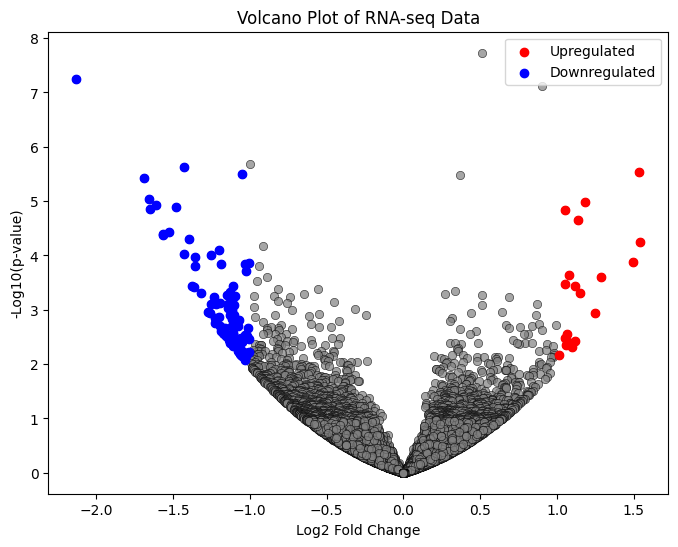

In [ ]:

# -----------------------------------------------------------------------------
# 2. Create a volcano plot
# -----------------------------------------------------------------------------
df['minus_log10_pvalue'] = -np.log10(df['pvalue'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='log2FoldChange', y='minus_log10_pvalue',
                edgecolor='k', color='gray', alpha=0.7)
plt.title("Volcano Plot of RNA-seq Data")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")

# Highlight upregulated (Log2FC > 1, pvalue < 0.01) in red
upregulated = df[(df['log2FoldChange'] > 1) & (df['pvalue'] < 0.01)]
plt.scatter(upregulated['log2FoldChange'],
            upregulated['minus_log10_pvalue'],
            color='red', label='Upregulated')

# Highlight downregulated (Log2FC < -1, pvalue < 0.01) in blue
downregulated = df[(df['log2FoldChange'] < -1) & (df['pvalue'] < 0.01)]
plt.scatter(downregulated['log2FoldChange'],
            downregulated['minus_log10_pvalue'],
            color='blue', label='Downregulated')

plt.legend()
plt.show()


In [ ]:

# 3. Determine upregulated and downregulated genes

up_genes = upregulated['Gene'].tolist()
down_genes = downregulated['Gene'].tolist()
print(f"Number of upregulated genes: {len(up_genes)}")
print(f"Number of downregulated genes: {len(down_genes)}")

# 4. Identify the top 5 upregulated and top 5 downregulated genes

# Sort upregulated by descending log2FoldChange
top5_up = upregulated.sort_values(by='log2FoldChange', ascending=False).head(5)
# Sort downregulated by ascending log2FoldChange
top5_down = downregulated.sort_values(by='log2FoldChange', ascending=True).head(5)

print("\nTop 5 Upregulated Genes:")
print(top5_up[['Gene', 'log2FoldChange', 'pvalue']])

print("\nTop 5 Downregulated Genes:")
print(top5_down[['Gene', 'log2FoldChange', 'pvalue']])




Number of upregulated genes: 19
Number of downregulated genes: 91

Top 5 Upregulated Genes:
       Gene  log2FoldChange    pvalue
20    DTHD1           1.540  0.000056
5   EMILIN2           1.534  0.000003
29     PI16           1.495  0.000130
34  C4orf45           1.288  0.000247
74  FAM180B           1.249  0.001146

Top 5 Downregulated Genes:
       Gene  log2FoldChange        pvalue
1      TBX5          -2.129  5.655000e-08
3    IFITM1          -1.687  3.735000e-06
9       TNN          -1.658  8.973000e-06
11  COL13A1          -1.647  1.394000e-05
12   IFITM3          -1.610  1.202000e-05


In [ ]:
!pip install mygene

In [ ]:
# !pip install mygene

import mygene

mg = mygene.MyGeneInfo()

top_up_genes = top5_up['Gene'].tolist()
top_down_genes = top5_down['Gene'].tolist()

up_info = mg.querymany(top_up_genes, scopes='symbol', fields='name,summary', species='human')
down_info = mg.querymany(top_down_genes, scopes='symbol', fields='name,summary', species='human')

print("\nTop 5 Upregulated Genes Info:")
for gene in up_info:
    print(f"{gene['query']} - {gene.get('name', 'N/A')}: {gene.get('summary', 'No summary available')}")

print("\nTop 5 Downregulated Genes Info:")
for gene in down_info:
    print(f"{gene['query']} - {gene.get('name', 'N/A')}: {gene.get('summary', 'No summary available')}")


INFO:biothings.client:querying 1-5 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-5 ...
INFO:biothings.client:Finished.



Top 5 Upregulated Genes Info:
DTHD1 - death domain containing 1: This gene encodes a protein which contains a death domain. Death domain-containing proteins function in signaling pathways and formation of signaling complexes, as well as the apoptosis pathway. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Oct 2012].
EMILIN2 - elastin microfibril interfacer 2: Predicted to enable extracellular matrix constituent conferring elasticity. Predicted to be involved in cell adhesion. Located in extracellular region. [provided by Alliance of Genome Resources, Apr 2022]
PI16 - peptidase inhibitor 16: Predicted to enable peptidase inhibitor activity. Predicted to be involved in negative regulation of peptidase activity. Predicted to act upstream of or within negative regulation of cell growth involved in cardiac muscle cell development. Predicted to be active in extracellular space. [provided by Alliance of Genome Resources, Apr 2022]
C4orf45 - N/A: No summary

# <span style="display: block; text-align: center; color: gold;">Task 2.5 </span>


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


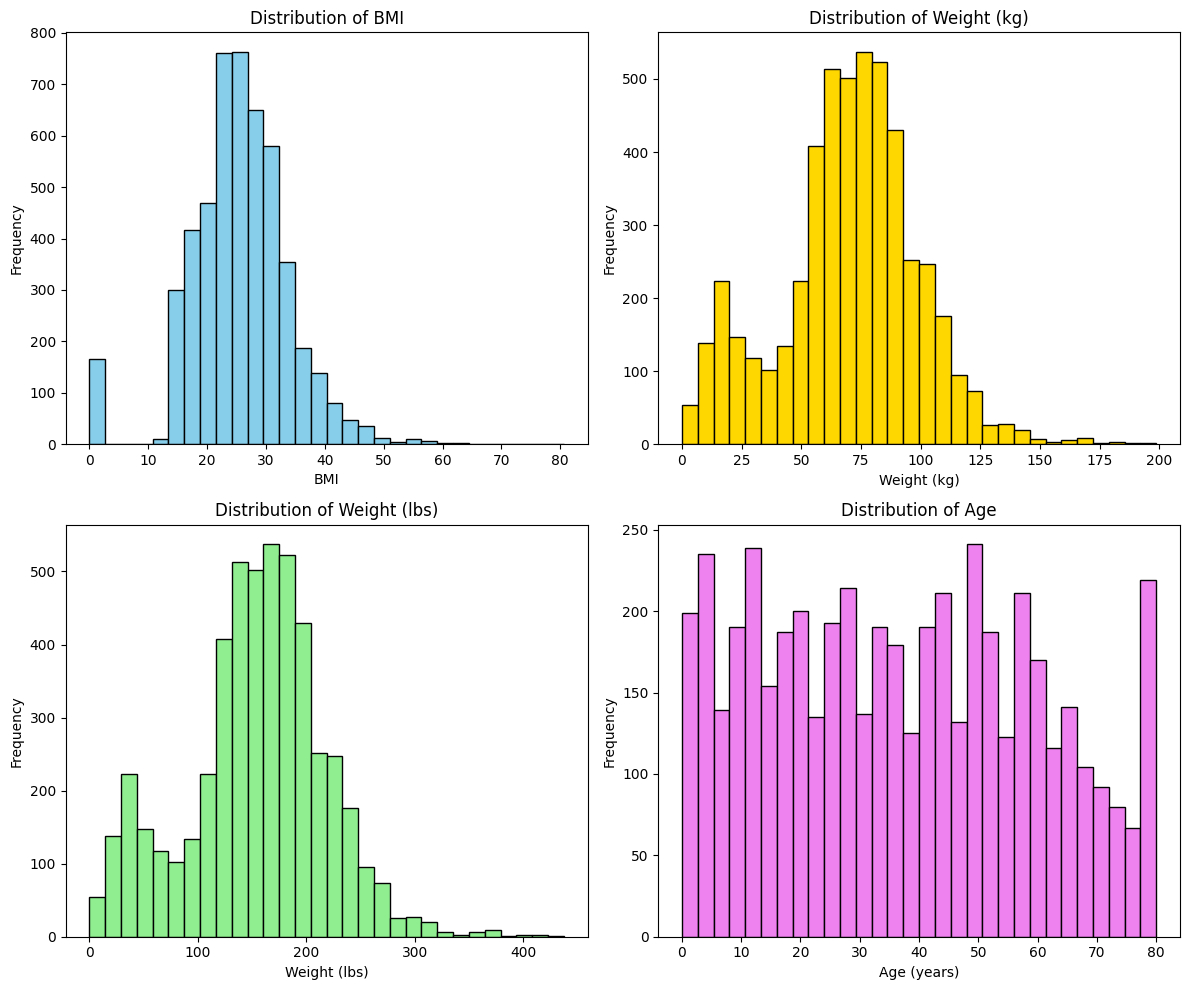

In [8]:

# 1. Load the NHANES dataset and process missing values

url = "https://raw.githubusercontent.com/HackBio-Internship/public_datasets/main/R/nhanes.csv"
df = pd.read_csv(url)

# Process missing values: here we choose to fill NAs with 0 (alternative: df.dropna())
df_clean = df.fillna(0)


# 2. Visualize distributions with histograms:
#   BMI, Weight (kg), Weight in pounds (Weight * 2.2), and Age

plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
plt.hist(df_clean['BMI'], bins=30, color='skyblue', edgecolor='k')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.subplot(2,2,2)
plt.hist(df_clean['Weight'], bins=30, color='gold', edgecolor='k')
plt.title('Distribution of Weight (kg)')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')

plt.subplot(2,2,3)
plt.hist(df_clean['Weight'] * 2.2, bins=30, color='lightgreen', edgecolor='k')
plt.title('Distribution of Weight (lbs)')
plt.xlabel('Weight (lbs)')
plt.ylabel('Frequency')

plt.subplot(2,2,4)
plt.hist(df_clean['Age'], bins=30, color='violet', edgecolor='k')
plt.title('Distribution of Age')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [ ]:

# 3. Mean 60-second pulse rate for all participants

mean_pulse = df_clean['Pulse'].mean()
print("Mean 60-second pulse rate:", mean_pulse)
# Expected output: ~73.63382


# 4. Range of values for diastolic blood pressure (BPDia)

min_dia = df_clean['BPDia'].min()
max_dia = df_clean['BPDia'].max()
print("Diastolic Blood Pressure range:", min_dia, "-", max_dia)
# Expected output: 0-116


# 5. Variance and standard deviation for income

income_variance = df_clean['Income'].var()
income_std = df_clean['Income'].std()
print("Income variance:", income_variance)
print("Income standard deviation:", income_std)



Mean 60-second pulse rate: 63.06
Diastolic Blood Pressure range: 0.0 - 116.0
Income variance: 1264147753.5507102
Income standard deviation: 35554.85555519401


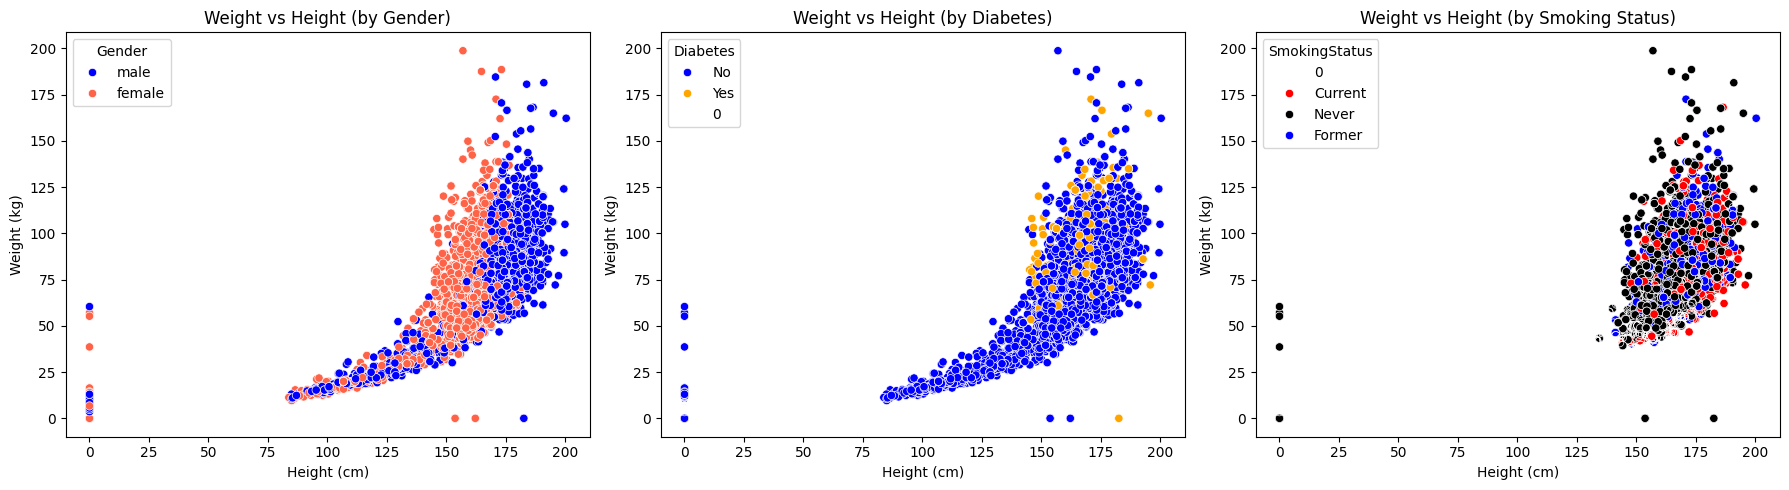

In [ ]:


# 6. Visualize the relationship between Weight and Height
#    Color the points by:
#      - Gender
#      - Diabetes
#      - SmokingStatus

plt.figure(figsize=(18, 5))

# Plot 1: Weight vs Height by Gender
# Assuming Gender is coded as 'male' and 'female'
gender_palette = {'male': 'blue', 'female': 'tomato'}  # blue and red-orange
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_clean, x='Height', y='Weight', hue='Gender', palette=gender_palette)
plt.title('Weight vs Height (by Gender)')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

# Plot 2: Weight vs Height by Diabetes
# Assuming Diabetes is coded as 'Yes' and 'No'
diabetes_palette = {'Yes': 'orange', 'No': 'blue'}  # red vs green
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_clean, x='Height', y='Weight', hue='Diabetes', palette=diabetes_palette)
plt.title('Weight vs Height (by Diabetes)')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

# Plot 3: Weight vs Height by Smoking Status
# Assuming SmokingStatus has categories such as 'Current', 'Former', 'Never'
smoking_palette = {'Current': 'red', 'Former': 'blue', 'Never': 'black'}  # distinct contrasting colors
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_clean, x='Height', y='Weight', hue='SmokingStatus', palette=smoking_palette)
plt.title('Weight vs Height (by Smoking Status)')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

plt.tight_layout()
plt.show()



In [ ]:
# 7. Conduct t-tests between specified groups and interpret p-values



# Compare Age between male and female participants.
male_age = df_clean[df_clean['Gender'] == 'male']['Age']
female_age = df_clean[df_clean['Gender'] == 'female']['Age']
t_stat_age_gender, p_val_age_gender = stats.ttest_ind(male_age, female_age, equal_var=False)
print("T-test for Age by Gender: t =", t_stat_age_gender, ", p =", p_val_age_gender)
# Interpretation: A small p-value (<0.05) indicates a significant difference in age distributions between genders.


# Compare BMI for participants with Diabetes "Yes" vs "No".
bmi_diabetes_yes = df_clean[df_clean['Diabetes'] == 'Yes']['BMI']
bmi_diabetes_no = df_clean[df_clean['Diabetes'] == 'No']['BMI']
t_stat_bmi_diabetes, p_val_bmi_diabetes = stats.ttest_ind(bmi_diabetes_yes, bmi_diabetes_no, equal_var=False)
print("T-test for BMI by Diabetes: t =", t_stat_bmi_diabetes, ", p =", p_val_bmi_diabetes)
# Interpretation: A small p-value indicates BMI is significantly different between those with and without diabetes.


# Compare AlcoholYear between participants who are "Committed" vs "Single"
alcohol_committed = df_clean[df_clean['RelationshipStatus'] == 'Committed']['AlcoholYear']
alcohol_single = df_clean[df_clean['RelationshipStatus'] == 'Single']['AlcoholYear']
t_stat_alcohol, p_val_alcohol = stats.ttest_ind(alcohol_committed, alcohol_single, equal_var=False)
print("T-test for AlcoholYear by RelationshipStatus: t =", t_stat_alcohol, ", p =", p_val_alcohol)
# Interpretation: A small p-value would indicate a significant difference in alcohol consumption frequency between relationship groups.


T-test for Age by Gender: t = -1.7497609657905853 , p = 0.0802210036256281
T-test for BMI by Diabetes: t = 13.912087307486564 , p = 1.721330839025317e-36
T-test for AlcoholYear by RelationshipStatus: t = 5.532972820924701 , p = 3.3881842163815174e-08


In [ ]:
# Comment on T-test Results:

# Age by Gender:
# The t-test comparing age between male and female participants yielded a t-statistic
# of -1.75 and a p-value of 0.08. Since the p-value is above the common threshold of
# 0.05, we conclude that there is no statistically significant difference in age between
# genders in this dataset.


# BMI by Diabetes:
# The t-test for BMI between participants with and without diabetes produced a
# t-statistic of 13.91 and a p-value on the order of 1.72e-36. This extremely
# low p-value indicates a highly significant difference in BMI based on diabetes
# status, suggesting that BMI is strongly associated with whether a participant
# has diabetes.


# AlcoholYear by RelationshipStatus:
# For the comparison of annual alcohol consumption (AlcoholYear) by relationship
# status, the t-test resulted in a t-statistic of 5.53 and a p-value of 3.39e-08.
# This significant result indicates that alcohol consumption differs markedly
# between participants who are in committed relationships versus those who are single.

# These results imply that while age does not significantly differ by gender,
# both BMI and alcohol consumption are significantly related to diabetes
# status and relationship status, respectively.